In [1]:
# Load modules

import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
sys.path.append('..')
from types import SimpleNamespace
from field_of_junctions import FieldOfJunctions
import nbimporter

from torchsummary import summary

from Dataset_Maker_Lines import make_random_line_set, make_grey_transform
from Dataset_Maker_Junctions import make_random_junction_set, make_grey_transform_junc

# %load_ext autoreload
# %reload_ext autoreload

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [113]:
# all_angles = torch.linspace(0,2*torch.pi,100)

# plt.figure()
# plt.subplot(121)
# plt.plot(all_angles,torch.abs(torch.cos(all_angles)))
# plt.subplot(122)
# plt.plot(all_angles,torch.abs(1/torch.cos(all_angles)))


# plt.figure()
# plt.subplot(121)
# plt.plot(all_angles,torch.abs(torch.sin(all_angles)))
# plt.subplot(122)
# plt.plot(all_angles[:-1],torch.abs(1/torch.sin(all_angles))[:-1])

In [114]:
# # Keep because this method does produce clean images HOWEVER I don't understand it well yet
# Stumbled upon it by accident

# ypatch,xpatch = torch.meshgrid(torch.linspace(-2,2,100),torch.linspace(-2,2,100))

# c = torch.sqrt(ypatch**2 + xpatch**2)
# a = -xpatch/c
# b = ypatch/c

# plt.figure()
# plt.imshow(c<torch.abs(1/xpatch))

# plt.figure()
# plt.imshow(c<torch.abs(1/ypatch))

# plt.figure()
# plt.imshow( (c<torch.abs(1/xpatch))*(c<torch.abs(1/ypatch)), extent=[-2,2,-2,2])

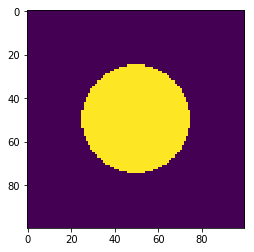

In [115]:
# Let's start with checking whether patches lie in a circle of radius 1

# c = distance from center to the perpendicular point on the line = sqrt(x^2 + y^2)

plt.figure()
plt.imshow(torch.sqrt(ypatch**2 + xpatch**2)<1)

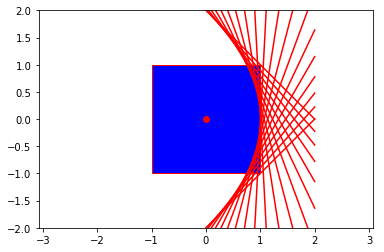

In [116]:
# One thing we can do is define a bunch of lines where [cx,cy] lie on the edge of the patch
# This gives us a visualization of how many of the lines will intersect with the patch

# Let's test theta in [-pi/4,pi/4]

plt.figure()
rectangle = plt.Rectangle((1,-1), -2, 2, fc='blue',ec="red")
plt.gca().add_patch(rectangle)
plt.plot(0,0,'ro')
plt.axis('equal')
plt.xlim([-2,2])
plt.ylim([-2,2])

for cy_ii in torch.linspace(-1,1,20):

    cx,cy = 1,cy_ii
    # theta = torch.pi/4

    c = np.sqrt(cx**2 + cy**2)
    a = -cx/c
    b = cy/c

    # y = (-a*x - c)/b

    x = torch.linspace(-2,2,100)
    y = (-a*x - c)/b

    plt.plot(x,y,'r-')


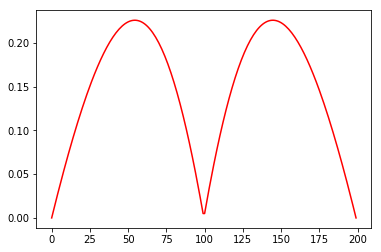

In [176]:
# One thing we can do is define a bunch of lines where [cx,cy] lie on the edge of the patch
# This gives us a visualization of how many of the lines will intersect with the patch

# Let's test theta in [-pi/4,pi/4]

plt.figure()
# rectangle = plt.Rectangle((1,-1), -2, 2, fc='blue',ec="red")
# plt.gca().add_patch(rectangle)
# plt.plot(0,0,'ro')
# plt.axis('equal')
# plt.xlim([-2,2])
# plt.ylim([-2,2])

line = []

for cy_ii in torch.linspace(-1,1,200):

    cx,cy = 1,cy_ii
    # theta = torch.pi/4

    c = np.sqrt(cx**2 + cy**2)
    a = -cx/c
    b = cy/c

    line.append(torch.abs(a)+torch.abs(b)-torch.abs(c))

plt.plot(line,'r-')



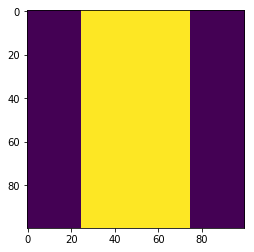

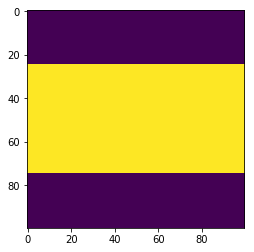

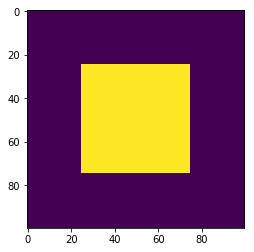

In [117]:
# An approximate solution is to allow for any lines where abs(cy)>1 AND abs(cx)>1
# However, there will be lines that do not intersect with the patch that are considered to intersect

ypatch,xpatch = torch.meshgrid(torch.linspace(-2,2,100),torch.linspace(-2,2,100))


c = torch.sqrt(ypatch**2 + xpatch**2)
a = -xpatch/c
b = ypatch/c

plot1 = torch.abs(c) < torch.abs(1/a)
plot2 = torch.abs(c) < torch.abs(1/b)

plt.figure()
plt.imshow(plot1)

plt.figure()
plt.imshow(plot2)


plt.figure()
plt.imshow(plot1*plot2)


# plt.figure()
# plt.imshow(torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/xpatch))

# plt.figure()
# plt.imshow( (torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/xpatch))*(torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/ypatch)))

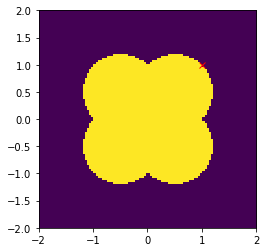

In [118]:
# The "true" solution is to only allow lines that do n ot intersect
# This is related to their distance away from the corner points

ypatch,xpatch = torch.meshgrid(torch.linspace(-2,2,100),torch.linspace(-2,2,100))


c = torch.sqrt(ypatch**2 + xpatch**2)
a = -xpatch/c
b = ypatch/c

plot1 =  (torch.abs(xpatch*a) + torch.abs(ypatch*b)) < (torch.abs(a) + torch.abs(b))
# plot2 = torch.abs(c) < torch.abs(1/b)

plt.figure()
plt.imshow(plot1, extent=[-2,2,-2,2])
plt.plot(1,1,'rx')

# plt.figure()
# plt.imshow(plot2)


# plt.figure()
# plt.imshow(plot1*plot2)


# plt.figure()
# plt.imshow(torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/xpatch))

# plt.figure()
# plt.imshow( (torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/xpatch))*(torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/ypatch)))

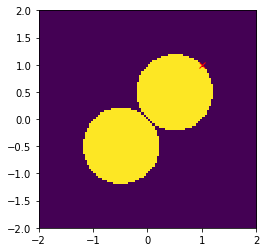

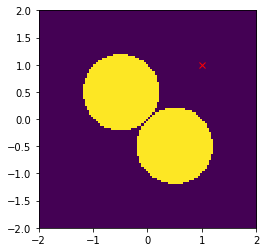

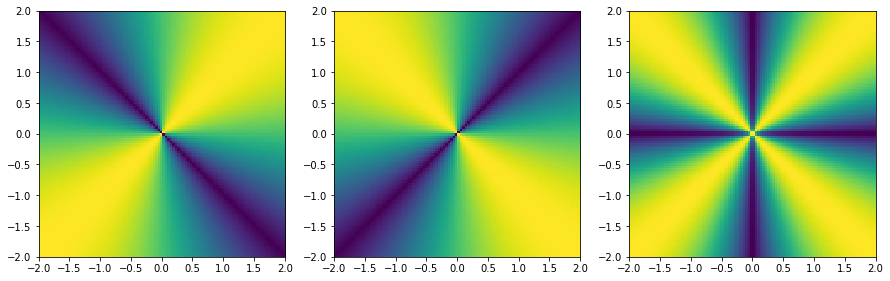

In [171]:
# The "true" solution is to only allow lines that do not intersect
# This is related to their distance away from the corner points

ypatch,xpatch = torch.meshgrid(torch.linspace(-2,2,100),torch.linspace(-2,2,100))


c = torch.sqrt(ypatch**2 + xpatch**2)
a = -xpatch/c
b = ypatch/c

plot1 =  torch.abs(-xpatch*a + ypatch*b) < (torch.abs(a + b))
plot2 = torch.abs(ypatch*b - xpatch*a) < (torch.abs(a - b))

plt.figure()
plt.imshow(plot1, extent=[-2,2,-2,2])
plt.plot(1,1,'rx')

plt.figure()
plt.imshow(plot2, extent=[-2,2,-2,2])
plt.plot(1,1,'rx')

# plt.figure()
# plt.imshow(torch.abs(a - b), extent=[-2,2,-2,2])
# plt.plot(1,1,'rx')

plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(torch.abs(a + b), extent=[-2,2,-2,2])
plt.subplot(132)
plt.imshow(torch.abs(a - b), extent=[-2,2,-2,2])
plt.subplot(133)
plt.imshow(torch.abs(a)+torch.abs(b), extent=[-2,2,-2,2])


# plt.figure()
# plt.imshow(c)



# plt.figure()
# plt.imshow(plot1*plot2)


# plt.figure()
# plt.imshow(torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/xpatch))

# plt.figure()
# plt.imshow( (torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/xpatch))*(torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/ypatch)))

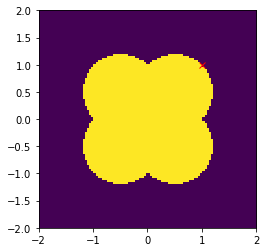

In [173]:
# The "true" solution is to only allow lines that do not intersect
# This is related to their distance away from the corner points

ypatch,xpatch = torch.meshgrid(torch.linspace(-2,2,100),torch.linspace(-2,2,100))


c = torch.sqrt(ypatch**2 + xpatch**2)
a = -xpatch/c
b = ypatch/c

plot1 =  torch.abs(c) < torch.abs(a) + torch.abs(b)
# plot2 = torch.abs(c) < torch.abs(1/b)

plt.figure()
plt.imshow(plot1, extent=[-2,2,-2,2])
plt.plot(1,1,'rx')

# plt.figure()
# plt.imshow(plot2)


# plt.figure()
# plt.imshow(plot1*plot2)


# plt.figure()
# plt.imshow(torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/xpatch))

# plt.figure()
# plt.imshow( (torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/xpatch))*(torch.sqrt(ypatch**2 + xpatch**2)<torch.abs(1/ypatch)))

torch.Size([2, 100, 100]) torch.Size([2, 1, 1])


Text(0.5, 1.0, 'Distance between (a,b,c) and (a,b,c) equivalent of (cx,cy)')

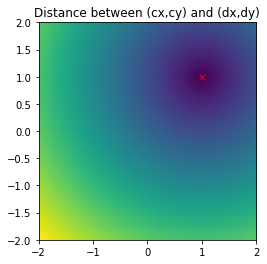

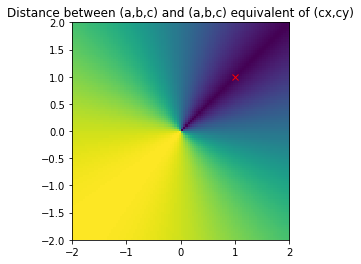

In [194]:
# Define ground truth cx,cy
c_pt = torch.tensor([1,-1]).unsqueeze(1).unsqueeze(2)

ypatch,xpatch = torch.meshgrid(torch.linspace(-2,2,100),torch.linspace(-2,2,100))

patch_stack = torch.stack((xpatch,ypatch))
 

plot1 = torch.sqrt(torch.sum((c_pt-patch_stack)**2,0))

plt.figure()
plt.imshow(plot1, extent=[-2,2,-2,2])
plt.plot(1,1,'rx')
plt.title('Distance between (cx,cy) and (dx,dy)')


ab_gt = torch.tensor((-c_pt[0]/torch.sqrt(torch.sum(c_pt**2)),c_pt[1]/torch.sqrt(torch.sum(c_pt**2)))).unsqueeze(1).unsqueeze(2)

ab = torch.stack((-xpatch/torch.sqrt(xpatch**2+ypatch**2),ypatch/torch.sqrt(xpatch**2+ypatch**2)))

print(ab.shape,ab_gt.shape)


plot2 = torch.sqrt(torch.sum((ab_gt-ab)**2,0))

plt.figure()
plt.imshow(plot2, extent=[-2,2,-2,2])
plt.plot(1,1,'rx')
plt.title('Distance between (a,b,c) and (a,b,c) equivalent of (cx,cy)')



Text(0.5, 1.0, 'Difference between gt (cx,cy) and (cx,cy) defined by grid of potential ')

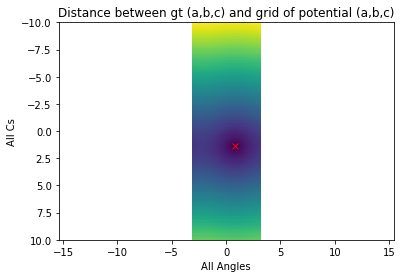

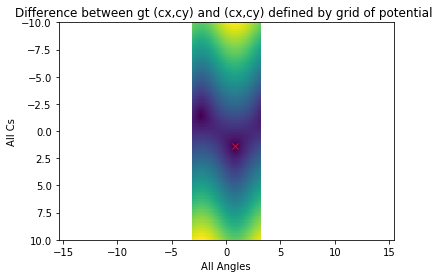

In [231]:
# Let's do it the other way

theta = torch.pi/4
px,py = 1,-1

a = -np.sin(theta)
b = np.cos(theta)
c = -py*np.cos(theta) + px*np.sin(theta)

abc_gt = torch.tensor((a,b,c)).unsqueeze(1).unsqueeze(2)

all_a = torch.linspace(-torch.pi,torch.pi,100)
all_c = torch.linspace(-10,10,100)

ypatch,xpatch = torch.meshgrid(all_c,all_a)

patch_stack = torch.stack((-torch.sin(xpatch),torch.cos(xpatch),ypatch))

plot1 = torch.sqrt(torch.sum((abc_gt-patch_stack)**2,0))

plt.figure()
plt.imshow(plot1, extent=[-torch.pi,torch.pi,10,-10])
plt.plot(theta,c,'rx')
plt.xlabel('All Angles')
plt.ylabel('All Cs')
plt.axis('equal')
plt.title('Distance between gt (a,b,c) and grid of potential (a,b,c)')


cxy_gt = torch.tensor((-a*c,b*c)).unsqueeze(1).unsqueeze(2)

cxy = torch.stack((torch.sin(xpatch)*ypatch,torch.cos(xpatch)*ypatch))

# print(cxy_gt.shape,cxy.shape)

plot2 = torch.sqrt(torch.sum((cxy_gt-cxy)**2,0))

plt.figure()
plt.imshow(plot2, extent=[-torch.pi,torch.pi,10,-10])
plt.plot(theta,c,'rx')
plt.xlabel('All Angles')
plt.ylabel('All Cs')
plt.axis('equal')
plt.title('Difference between gt (cx,cy) and (cx,cy) defined by grid of potential ')





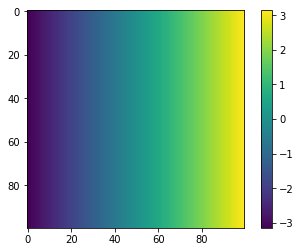

In [218]:
plt.figure()
plt.imshow(xpatch)
plt.colorbar()